## Clustering Morphologies Using [Persistent Homology](https://en.wikipedia.org/wiki/Topological_data_analysis)

The distance metric is a p-norm between persistence landscapes generated from sub-level set filtrations over neuronal trees. See [Kanari, L., Dłotko, P., Scolamiero, M. et al. A Topological Representation of Branching Neuronal Morphologies. Neuroinform 16, 3–13 (2018)](https://link.springer.com/article/10.1007/s12021-017-9341-1) for the filtration approach.

For a primer on persistence landscapes, see [Bubenik, P.. (2015). Statistical topological data analysis using persistence landscapes. Journal of Machine Learning Research. 16. 77-102. ](http://jmlr.org/papers/v16/bubenik15a.html)

We can compute both persistence diagrams and landscapes directly from neuronal reconstructions using SNT's [PersistenceAnalyzer](https://morphonets.github.io/SNT/sc/fiji/snt/analysis/PersistenceAnalyzer.html) class

As usual, we 1) initialize Fiji with GUI support (see [Overview](1_overview.ipynb) for details on how to link your local Fiji installation to this notebook); 2) import all relevant python modules; and 3) import all relevant SNT classes:

In [1]:
import ijfinder
import imagej
import os

fiji_path = ijfinder.getpath().decode('utf-8')
if os.path.isdir(fiji_path):
    ij = imagej.init(fiji_path, headless=False)
else:
    print("Cannot proceed: Fiji not found!")

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, ward

In [3]:
from jnius import autoclass, cast
Tree = autoclass('sc.fiji.snt.Tree')
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
PersistenceAnalyzer = autoclass('sc.fiji.snt.analysis.PersistenceAnalyzer')
AllenUtils = autoclass('sc.fiji.snt.annotation.AllenUtils')
Viewer3D = autoclass('sc.fiji.snt.viewer.Viewer3D')
ColorTables = autoclass('net.imagej.display.ColorTables')

In [4]:
def fetch_reconstructions(id_list, group_label):
    tree_list = []
    for tree_id in id_list:
        loader = MouseLightLoader(tree_id)
        if not loader.isDatabaseAvailable(): 
            print("Database not available. Exiting...")
            continue
        if not loader.idExists(): 
            print("Id not found in database. Exiting...")
            continue
        # Only compare axon topologies
        tree = loader.getTree('axon')
        tree_map[tree.getLabel()[0:6]] = tree
        tree.setLabel(tree.getLabel() + ' ' + group_label)
        tree_list.append(tree)
        
    return tree_list


def get_landscapes(trees, resolution, num_landscapes):
    landscapes = []
    for tree in trees:  
        """
        Obtain the Persistence Landscape as a N-dimensional vector,
        where N == resolution x number of landscapes.
        We use the geodesic distance descriptor function.
        The returned data type is a Java Array, so we must convert it to the equivalent
        Python representation by using the ij.py.from_java() method.
        """
        ls = ij.py.from_java(PersistenceAnalyzer(tree).getLandscape('geodesic', resolution, num_landscapes))
        landscapes.append(ls)
        
    return np.array(landscapes)
    
    
def get_distance_matrix(landscapes):
    t0 = time.time()
    # We can choose any of the p norms as metric
    distance_matrix = pairwise_distances(landscapes, metric='manhattan')
    t1 = time.time()
    print(t1-t0, ' seconds to compute all distances')

    return distance_matrix


def hcluster(distance_matrix, labels):
    # Perform Hierarchical Clustering on the landscape distance matrix and plot a dendrogram
    # of the resulting linkage matrix.
    
    # Convert to n-choose-2 dimensional vector to pass to linkage function
    mat_arr = squareform(distance_matrix)

    linkage_matrix = ward(mat_arr) #define linkage_matrix using Ward's method

    fig, ax = plt.subplots(figsize=(7, 10)) # set size
    dendrogram(linkage_matrix, orientation='right', labels=labels) 
    plt.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    plt.tight_layout()
    #plt.savefig('./images/ward_clusters.png', dpi=300)
    
    
def get_group_viewers(compare):
    viewers = []
    for pair in compare:
        true_labels = []
        v = Viewer3D()
        v.loadRefBrain('mouse')
        v.setViewMode('sagittal')
        for t in pair:
            v.addTree(tree_map[t])
            true_labels.append(tree_map[t].getLabel())

        v.colorCode(ij.py.to_java(true_labels), 'length', ColorTables.ICE)
        viewers.append(v)

    return viewers

Two types of mouse neuron from Layer 5 and 6 of motor cortex with differing projection patterns described in 
Winnubst et al. Cell 2019  
pre print at https://www.biorxiv.org/content/10.1101/537233v1

The first group is comprised of Layer 6 Corticothalamic neurons, which project primarily to Thalamus.

The second group contains Layer 5 pyramidal tract neurons, which can be further subdivided into two groups 
based on projection patterns: 
One sub-type projects to Thalamus, while the other projects to Medulla.

The two sub-types of Layer 5 PT neuron have distinct transcriptional profiles and functional roles, which are
elucidated in Economo et al. Nature 2018.  
pre-print at https://www.biorxiv.org/content/10.1101/229260v1

In [5]:
tree_map = {}     # global

corticothalamic = ['AA0039', 'AA0101', 'AA0103', 'AA0105', 'AA0188', 'AA0278', 'AA0390', 'AA0394', 
                  'AA0406', 'AA0577', 'AA0599', 'AA0633', 'AA0650', 'AA0781', 'AA0784', 'AA0799', 
                  'AA0817', 'AA0837', 'AA0838', 'AA0844']  

pt_thalamic = ["AA0011", "AA0114", "AA0115", "AA0122", "AA0181", "AA0182", "AA0245", "AA0261"]   

pt_medulla = ["AA0012", "AA0133", "AA0179", "AA0180"]

We can fetch all of these cells from the [MouseLight database](https://ml-neuronbrowser.janelia.org/) using SNT's [MouseLightLoader](https://morphonets.github.io/SNT/sc/fiji/snt/io/MouseLightLoader.html) class

In [6]:
corticothalamic_trees = fetch_reconstructions(corticothalamic, 'Layer 6 CT')
pt_thalamic_trees = fetch_reconstructions(pt_thalamic, 'Layer 5 PT-THAL')
pt_medulla_trees = fetch_reconstructions(pt_medulla, 'Layer 5 PT-MED')

We can compute the persistence landscapes for all cells, compute the distance matrix, and perform hierarchical clustering

In [7]:
all_trees = corticothalamic_trees + pt_thalamic_trees + pt_medulla_trees
all_labels = [t.getLabel() for t in all_trees]

In [8]:
resolution = 1000
num_landscapes = 1000
landscapes = get_landscapes(all_trees, resolution, num_landscapes)

Let's visualize the persistence landscape for one reconstruction

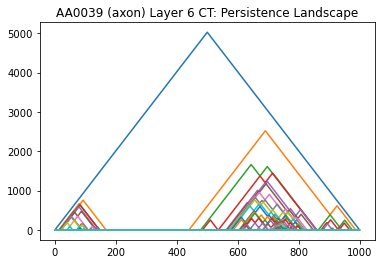

In [9]:
ls_split = np.array(np.split(landscapes[0], num_landscapes))
plt.plot(np.arange(resolution), ls_split.T)
plt.title("{}: Persistence Landscape".format(all_trees[0].getLabel()))
plt.show()

In [10]:
distance_matrix = get_distance_matrix(landscapes)

0.8424677848815918  seconds to compute all distances


As shown in the following dendrogram, we are able to distinguish cell types both within and between layers on the basis of topology alone

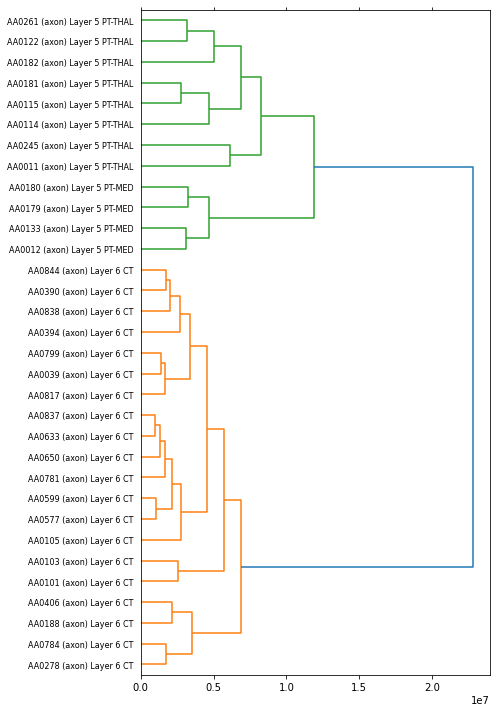

In [11]:
hcluster(distance_matrix, all_labels)

Lets plot a pair of neighboring cells in each clustered cell-type

In [12]:
compare = [['AA0181', 'AA0115'], ['AA0133', 'AA0012'], ['AA0784', 'AA0278']]
viewers = get_group_viewers(compare)

# We can also retrieve meshes of the relevant Allen CCF compartments
somatomotor_mesh = AllenUtils.getCompartment("Somatomotor areas").getMesh()
thalamus_mesh = AllenUtils.getCompartment("Thalamus").getMesh()
medulla_mesh = AllenUtils.getCompartment("Medulla").getMesh()

Layer 5 Pyramidal tract, Thalamic projecting

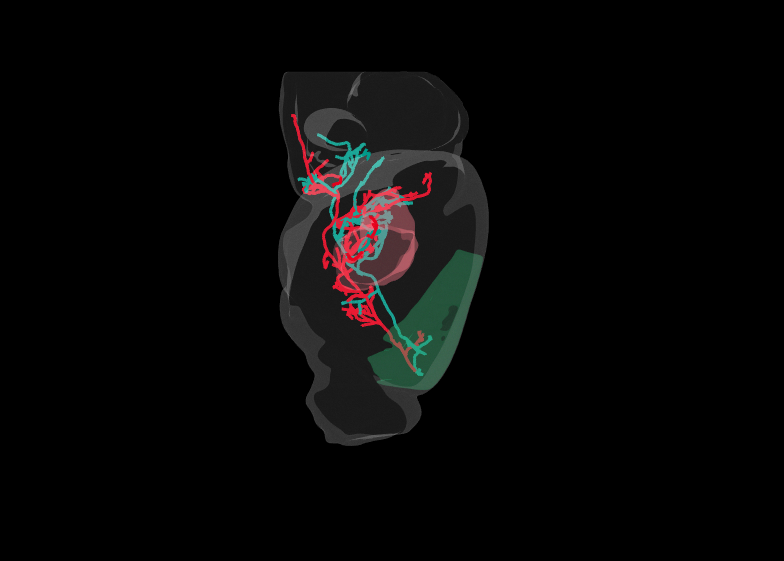

In [13]:
viewers[0].add(ij.py.to_java([somatomotor_mesh, thalamus_mesh]))
viewers[0].show()

# To embed the snapshot in this notebook
from IPython.display import Image, display
snapshot_path = os.getcwd() + '/images/group0exemplars.png'
viewers[0].saveSnapshot(snapshot_path)
display(Image(filename=snapshot_path))

Layer 5 Pyramidal tract, Medulla projecting

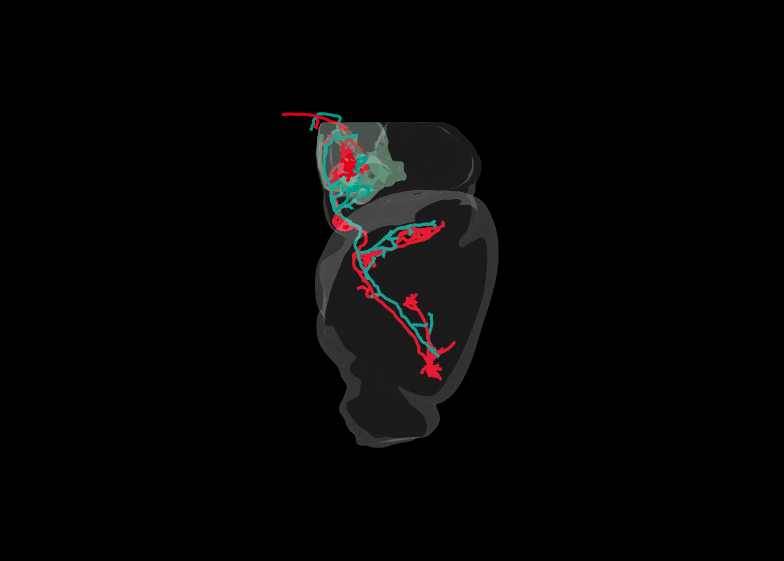

In [14]:
viewers[1].add(ij.py.to_java([somatomotor_mesh, medulla_mesh]))
viewers[1].show()

# To embed the snapshot in this notebook
snapshot_path = os.getcwd() + '/images/group1exemplars.png'
viewers[1].saveSnapshot(snapshot_path)
display(Image(filename=snapshot_path))

Layer 6 Corticothalamic

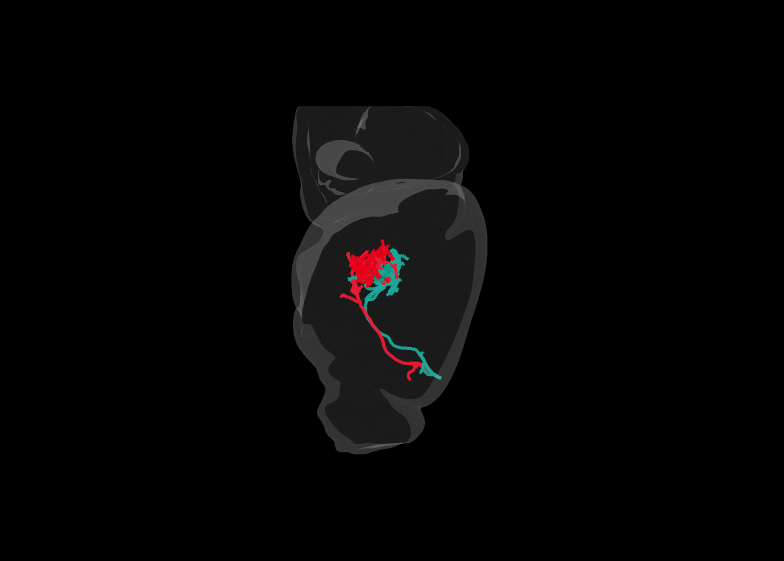

In [15]:
viewers[2].add(ij.py.to_java([somatomotor_mesh, medulla_mesh]))
viewers[2].show()

# To embed the snapshot in this notebook
snapshot_path = os.getcwd() + '/images/group2exemplars.png'
viewers[2].saveSnapshot(snapshot_path)
display(Image(filename=snapshot_path))